In [ ]:
!pip install orbipy
import numpy as np
import matplotlib.pyplot as plt
import orbipy as op
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 11.7 MB/s eta 0:00:00


In [ ]:
import model_integrator as modint
import event_integrator as evint

In [ ]:
from poincare1 import *

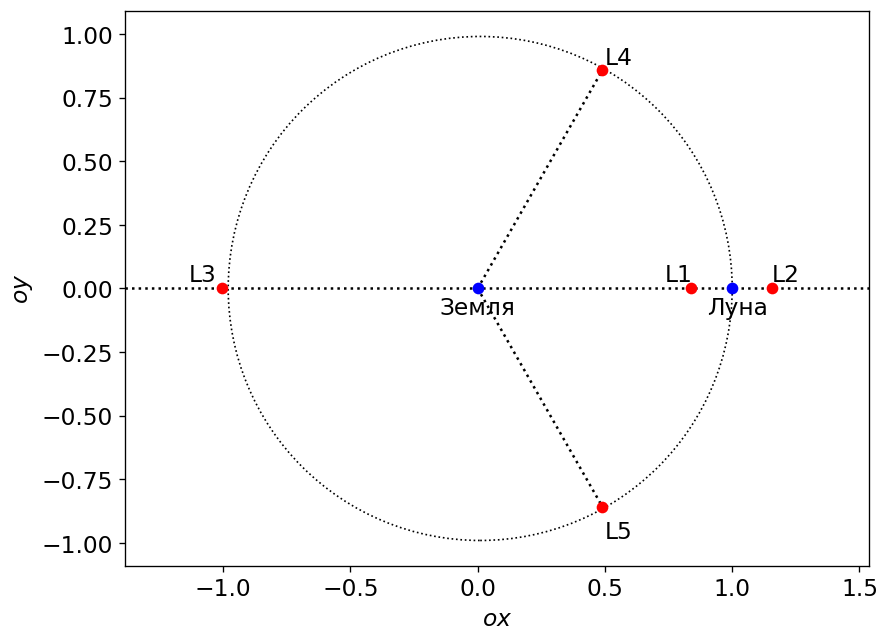

In [ ]:
model = modint.crtbp3_model('Earth-Moon (default)')
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
figure, axes = plt.subplots(figsize=(8, 6), dpi=120)
plt.xlabel("$ox$")
plt.ylabel("$oy$")
plt.text(-0.15, -0.1,'Земля')
plt.text(model.L1-0.1, 0.03,'L1')
plt.text(model.L2, 0.03,'L2')
plt.text(model.L3-0.13, 0.03,'L3')
plt.text(0.5, 0.88,'L4')
plt.text(0.5, -0.98,'L5')
plt.text(0.9, -0.1,'Луна')
x1 = (1-0.01)*((np.cos(np.pi/3))*(1-0.01))
y1 = (np.sin(np.pi/3))*(1-0.01)
plt.plot([0, x1], [0, y1], ':', color = 'black')
plt.plot([0, x1], [0, -y1], ':', color = 'black')
c = plt.Circle( (0.01, 0 ), radius = 1-0.01 ,fill = False, linestyle = ':')
axes.add_patch(c)
plt.axhline(y = 0, color = 'black', linestyle = ':', xmin = model.L3, xmax = model.L2)
plt.plot(0, 0, 'ro', color = 'blue')
plt.plot(model.L1, 0, 'ro')
plt.plot(model.L2, 0, 'ro')
plt.plot(model.L3, 0, 'ro')
plt.plot(x1, y1, 'ro')
plt.plot(x1, -y1, 'ro')
plt.plot(1, 0, 'ro', color = 'blue')
plt.axis('equal')
pdf = PdfPages("Figures.pdf")
pdf.savefig(figure)
pdf.close()

In [ ]:
np.sin(np.pi/6)

0.49999999999999994

# Расчёт семейств орбит

In [ ]:
stmmodelpol = modint.crtbp3_model('Earth-Moon (default)', stm=True, polar=True, stmp=True)

In [ ]:
model = modint.crtbp3_model('Earth-Moon (default)')

In [ ]:
# Гало орбиты
halo = pd.read_csv('halo_general_low_l2.csv')

In [ ]:
dp_EM = np.loadtxt('dp_EM.txt')

In [ ]:
# Уже поситанное семейство двухпериодиечксих орбит
dp = pd.read_csv('double_period_low_l2.csv')

In [ ]:
# Начальные условия известной периодической орбиты
x0, z0, v0 = dp.iloc[425, :3]
# Направление семейства
alpha = 1.8867553226030438

# Расчёт множителей Флоке
det_y0 = evint.event_detector(stmmodelpol, events=[op.eventY(count=4)])
y = stmmodelpol.get_zero_state()
y[[0, 2, 4]] = x0, z0, v0
arr, evout = det_y0.prop(y, 0, 20 * np.pi, last_state='last', ret_df=False)
Phi = evout[-1, -25:].reshape(5, 5)
mults = np.linalg.eigvals(Phi)

In [ ]:
# Список кортежей, в которых хранятся начальные условия решений и характеристики этих семейств
values0 = [(x0, z0, v0, alpha, 0, 0, *np.real(mults), *np.imag(mults), 0, 0, 0, 0, 0)]

In [ ]:
dp.iloc[388, :]

x        1.005737e+00
z        6.612952e-02
v        5.295611e-01
alpha    4.589577e+01
d22      1.404779e-14
t        1.754735e+00
Name: 388, dtype: float64

Данные начальные условия соответствуют орбите из семейства двухпериодических орбит. Эти орбиты пересекают плоскость $y=0$ 4 раза за один период.

In [ ]:
# Параметры оптимизаторов
dalpha = np.pi / 180 / 4
dalpha_max = dalpha * 2

dx = 1e-2
dxmax = 1e-3

# Размер шага при поиске новой точки семейства
R = 50 / model.R

# Имя файла, в которые будут сохраняться решения

In [ ]:
with open('dp_EM.txt', "w") as fname:
    np.savetxt(fname, dp_EM)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18,6))
# Создание объекта определения события пересечения плоскости 4 раза
det_y = evint.event_detector(stmmodelpol, events=[op.eventY(count=4)])

x0, z0, v0, alpha0 = values0[-1][:4]
ref = stmmodelpol.get_zero_state()
ref[0], ref[2], ref[4] = x0, z0, v0

for n in range(5):
    print('n', n+1, end=' ')

    alpha0, v1, d22, d22_mult = find_alpha_fm(ref, R, alpha0, n=4, model=stmmodelpol,
                                 alpha_dx=dalpha, alpha_dxmax=dalpha_max,
                                 v_dx=dx, v_dxmax=dxmax, beta=1, K=30)
    print('Goal function', d22_mult)
    print('v1', v1)

    x0 += R * np.cos(alpha0)
    z0 += R * np.sin(alpha0)
    v0 = v1

    ref = stmmodelpol.get_zero_state()
    ref[0], ref[2], ref[4] = x0, z0, v0
    arr, ev = det_y.prop(ref, 0., 20.*np.pi, last_state='last', ret_df=False)
    d2 = np.linalg.norm(ref[:3] - ev[-1, 4:7])**2
    t = ev[-1, 3] / np.pi
    Phi = ev[-1, -25:].reshape(5, 5)
    mults = np.linalg.eigvals(Phi)

    print("Distance", d2)
    print("Angle", alpha0 / np.pi * 180)

    if d22 > 1e-4:
        break

    values0.append((x0, z0, v0, alpha0, d2, t, *np.real(mults), *np.imag(mults), R, dalpha, dalpha_max, dx, dxmax))
    plotter.plot_proj(arr, ax=ax);

    print('-------------------------------------------------------------------------------')

In [ ]:
vals0 = np.array(values0)

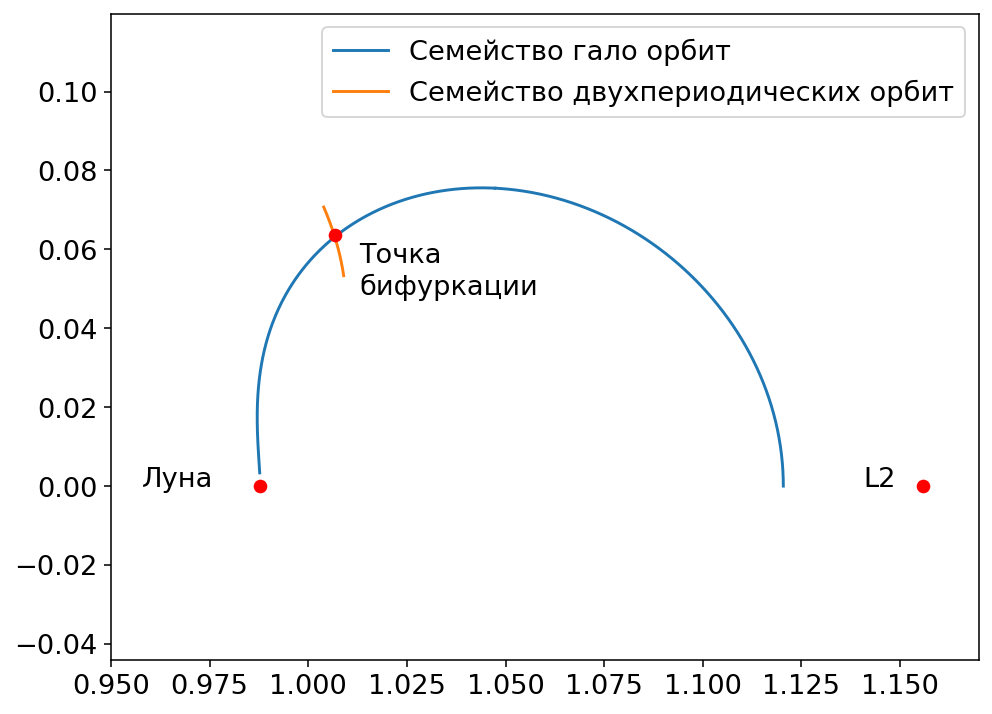

In [ ]:
# Карта начальных условий
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
figur2, axes = plt.subplots(figsize=(8, 6), dpi=140)
plt.axis('equal')
plt.xlim(0.95, 1.17)
plt.plot(halo.iloc[:, 0], halo.iloc[:, 1], '-', label = 'Семейство гало орбит')
plt.plot(dp.iloc[350:500, 0], dp.iloc[350:500, 1], '-', label = 'Семейство двухпериодических орбит')
#plt.plot(dp_EM[: , 0], dp_EM[: , 1], '-')
plt.text(model.L2-0.015, 0,'L2')
plt.text(model.mu1-0.03, 0,'Луна')
plt.text(dp.iloc[410, 0]+0.006, dp.iloc[410, 1]-0.015,'Точка\nбифуркации')
plt.plot(dp.iloc[410, 0], dp.iloc[410, 1], 'ro')
plt.plot(model.L2, 0, 'ro')
plt.plot(model.mu1, 0, 'ro')
plt.legend()
pdf = PdfPages("poins1.pdf")
pdf.savefig(figur2)
pdf.close()

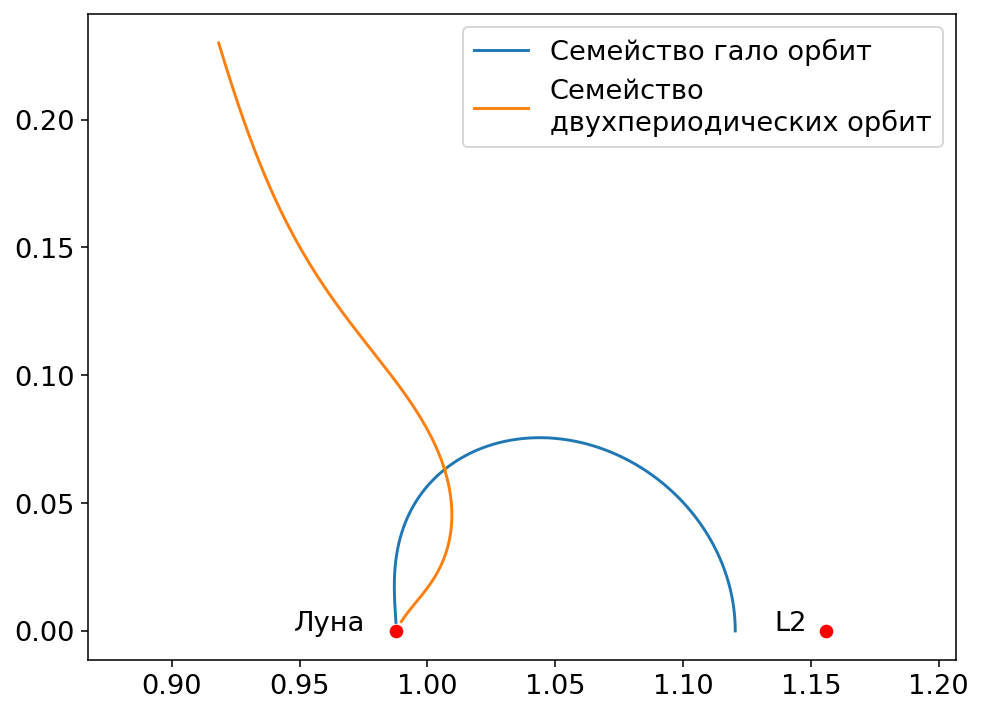

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.family"] = "Times New Roman"
figur3, axes = plt.subplots(figsize=(8, 6), dpi=140)
plt.axis('equal')
#plt.xlim(0.95, 1.17)
plt.plot(halo.iloc[:, 0], halo.iloc[:, 1], '-', label = 'Семейство гало орбит')
plt.plot(dp.iloc[:, 0], dp.iloc[:, 1], '-', label = 'Семейство\nдвухпериодических орбит')
#plt.plot(dp_EM[: , 0], dp_EM[: , 1], '-')
plt.text(model.L2-0.02, 0,'L2')
plt.text(model.mu1-0.04, 0,'Луна')
plt.plot(model.L2, 0, 'ro')
plt.plot(model.mu1, 0, 'ro')
plt.legend()
pdf = PdfPages("double_period.pdf")
pdf.savefig(figur3)
pdf.close()

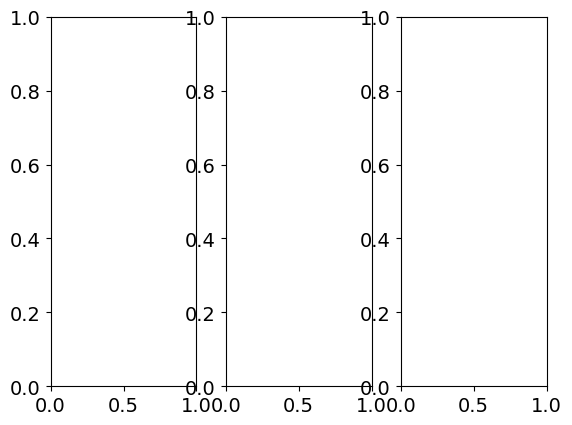

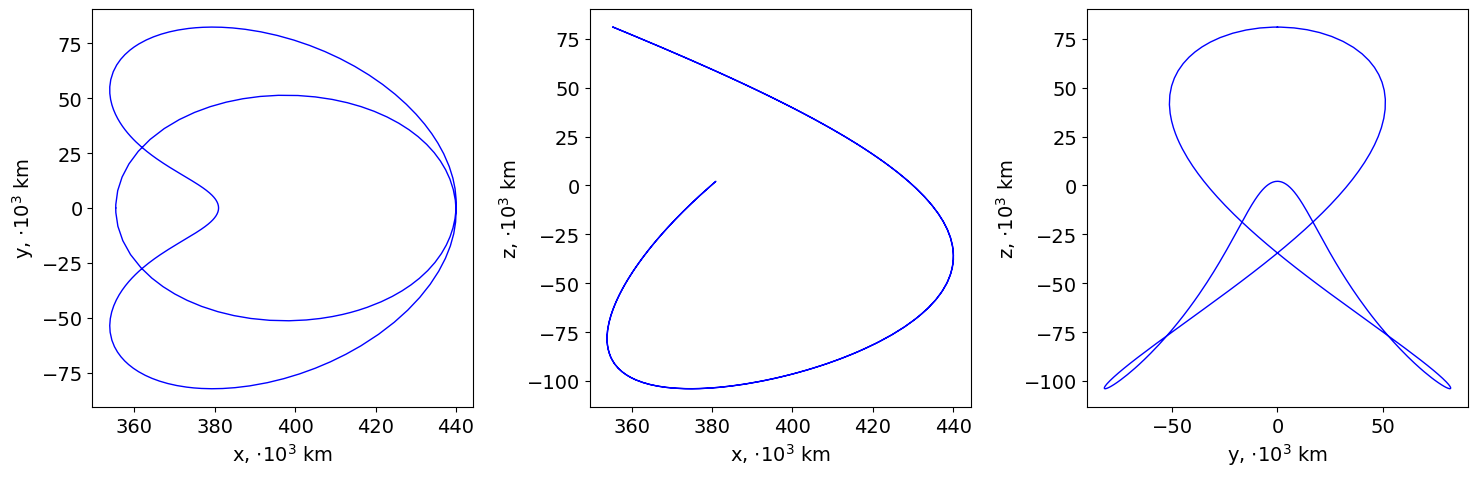

In [ ]:
figur4 = plt.subplots(nrows= 1 , ncols= 3 )
s = stmmodelpol.get_zero_state()
det_y = evint.event_detector(stmmodelpol, events=[op.eventY(count=4)])
s[[0, 2, 4]] = dp_EM[150, :3]
arr, ev = det_y.prop(s, 0, 4*np.pi, last_state='last', ret_df=False)
figur4 = plotter.plot_proj(arr, lw=1, alpha=1)
plt.savefig('trajectory.pdf')

In [ ]:
s

array([0., 0., 0., 0., 0., 0.])

In [ ]:
np.angle((dp.iloc[425] - dp.iloc[424])[0] + (dp.iloc[425] - dp.iloc[424])[1]*1j) + np.pi

1.8867553226030438

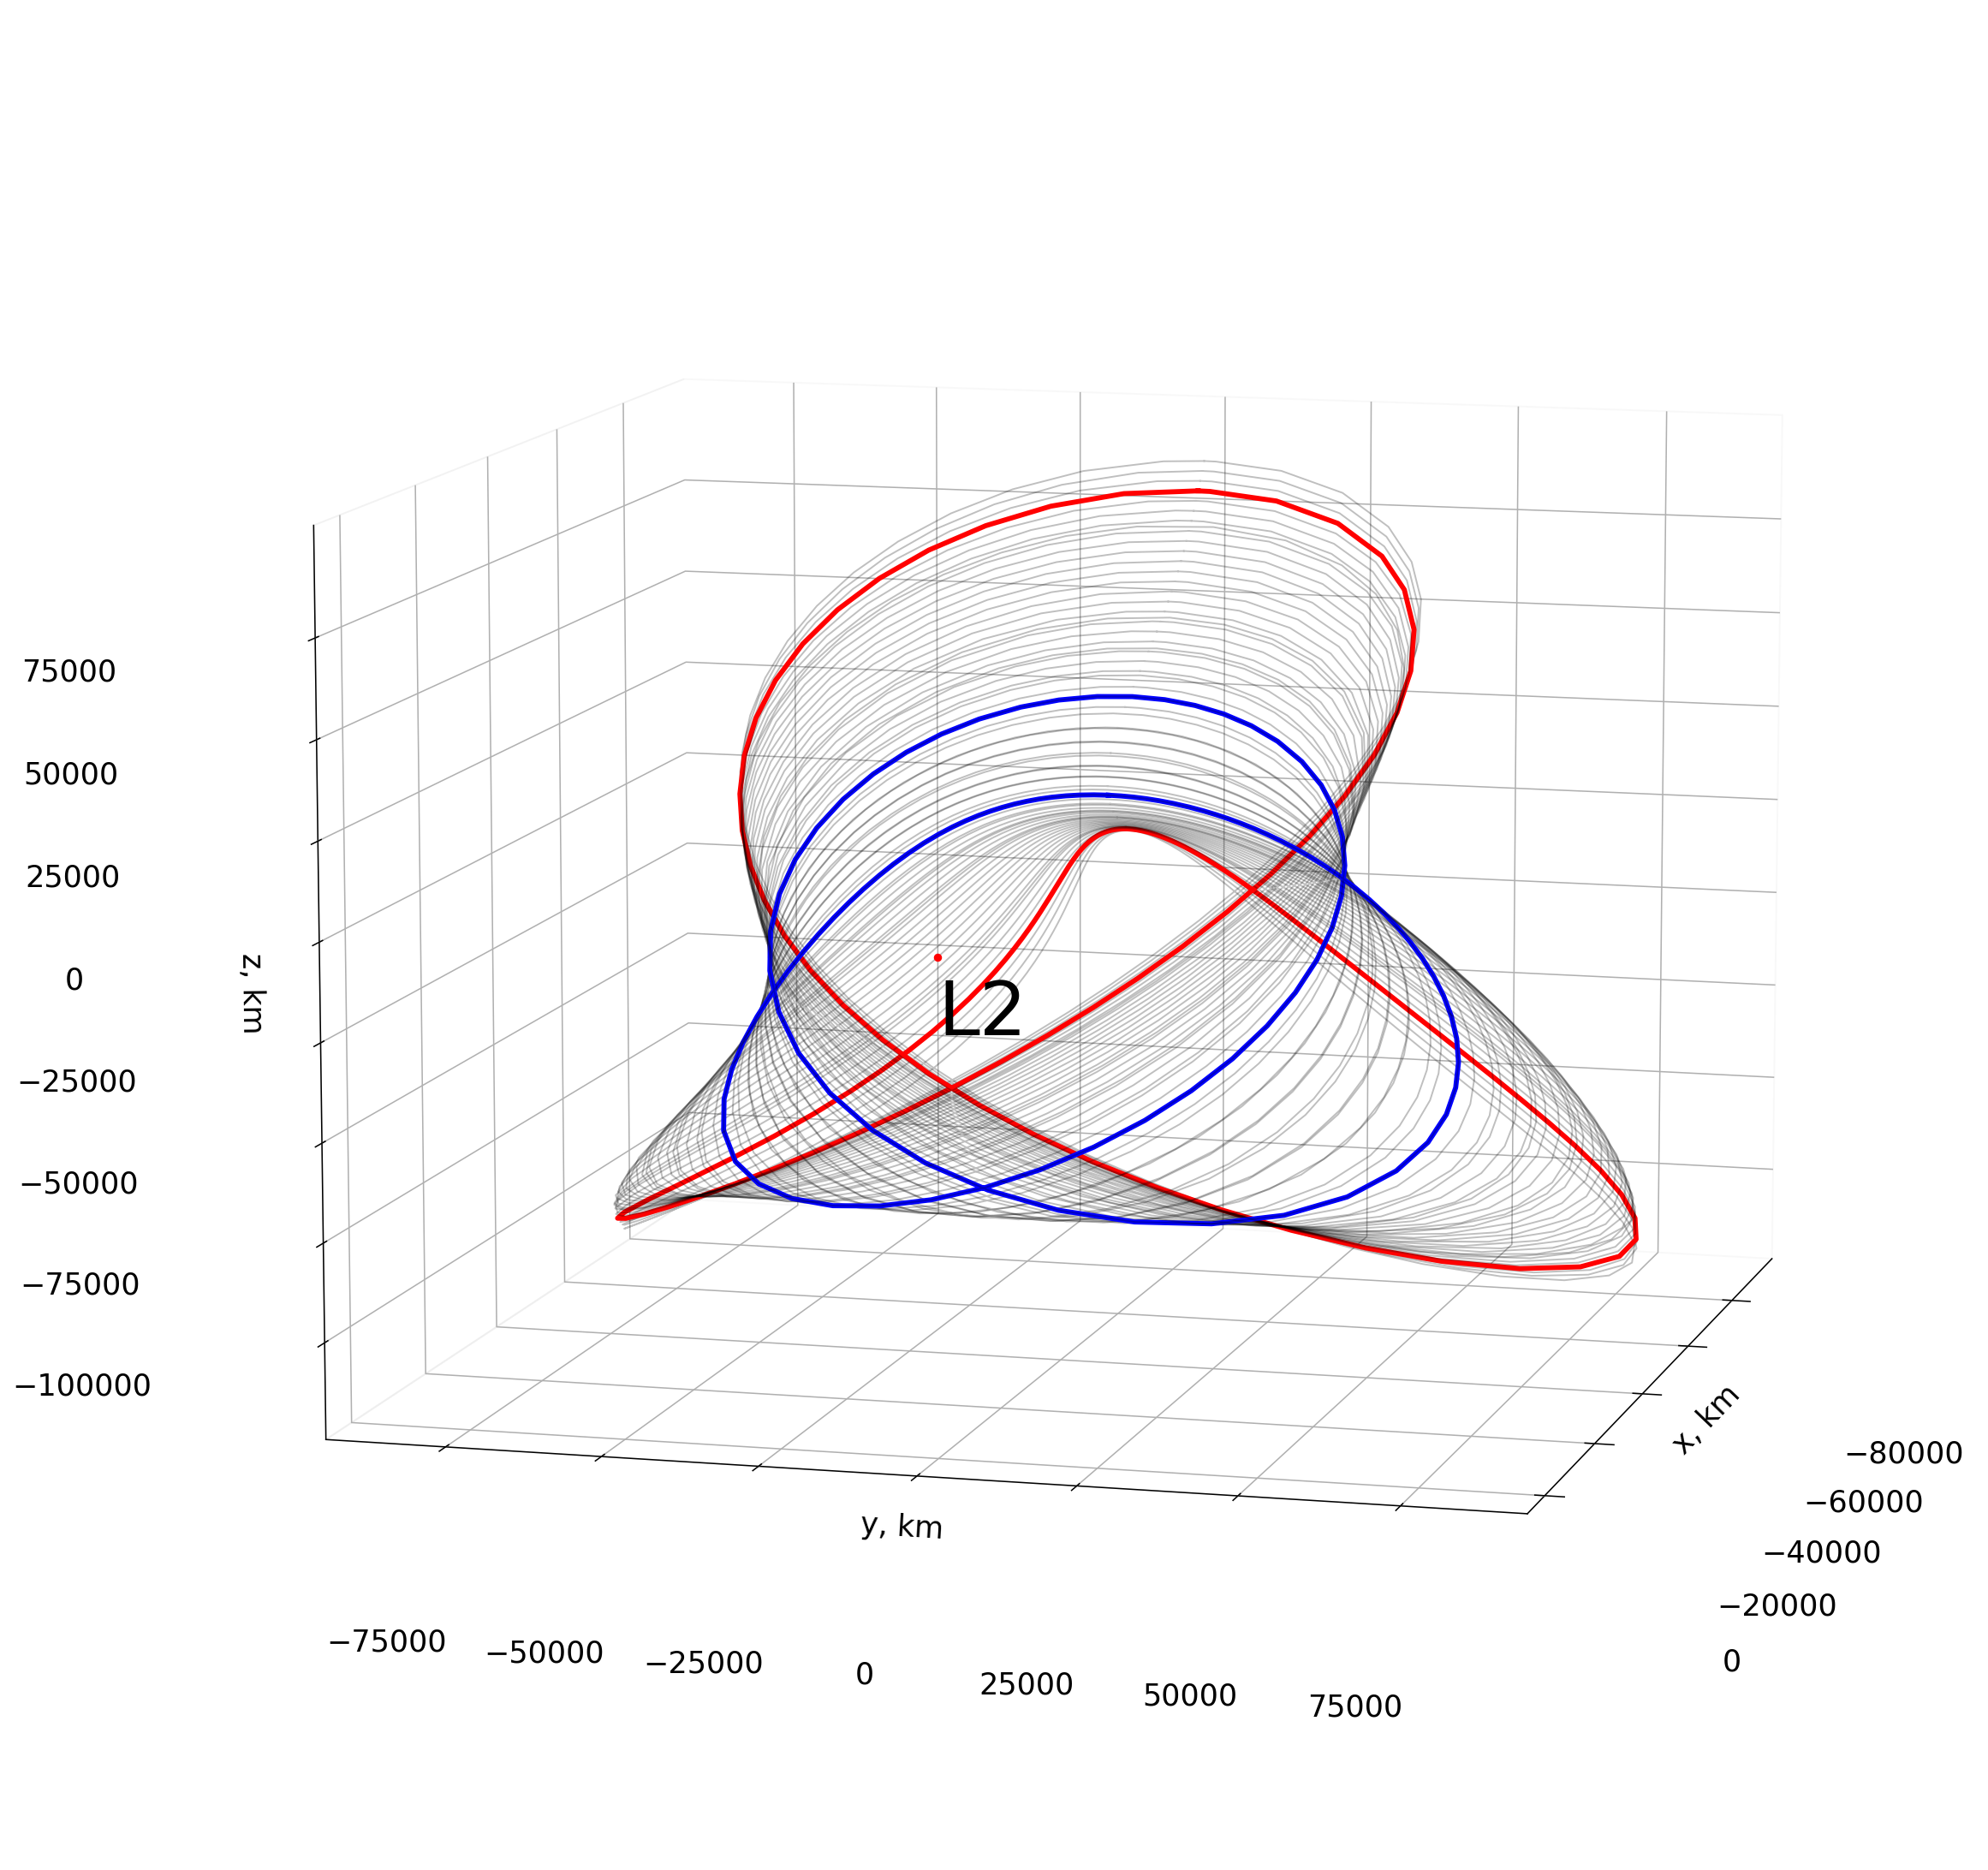

In [ ]:
# здесь задаётся список индексов орбит, которые вы хотите нарисовать
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

indlist = np.arange(0, 1738, 50)

fig = plt.figure(figsize=(20,20), dpi=140)
ax = fig.add_subplot(111, projection='3d')
det_y = evint.event_detector(model, events=[op.eventY(count=4)])
s = model.get_zero_state()
R = model.R
for i in indlist:
    s[0], s[2], s[4] = dp_EM[i, :3]
    arr, ev = det_y.prop(s, 0., 20.*np.pi, last_state='last')

    #   ax.set_facecolor("white")
    if i == 1500:
        ax.plot((arr.x-model.L2)*R, arr.y*R, arr.z*R, linewidth = 3, color='b')
    ax.plot((arr.x-model.L2)*R, arr.y*R, arr.z*R, linewidth = 1, color='k', alpha=0.25)
    if i == 150:
        ax.plot((arr.x-model.L2)*R, arr.y*R, arr.z*R, linewidth = 3, color='r')

ax.scatter(0, 0.0, 0.0,'O', color='red', s=15)
ax.text(0.1, 0.1, -0.05 * model.R,'L2', size=45)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.tick_params(pad = 80)
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')
ax.set_zlabel('z, km')

ax.view_init(10, 15)
pdf = PdfPages("3d2.pdf")
pdf.savefig(fig)
pdf.close()


In [ ]:
stmmodel = modint.crtbp3_model('Earth-Moon (default)', stm=True)
s0 = stmmodel.get_zero_state()
floke = np.array
for i in range(len(dp_EM)):
  s0[[0, 2, 4]] = dp_EM[i, :3]
  dety = evint.event_detector(stmmodel, events=[op.eventY(count=2)])
  arr, ev = dety.prop(s0, 0, 200 * np.pi, last_state='last', ret_df=False)
  Phi = ev[-1, -36:].reshape(6, 6)
  floke = np.append(floke, np.linalg.eigvals(Phi))

<Figure size 640x480 with 0 Axes>

(-0.1, 1.1)

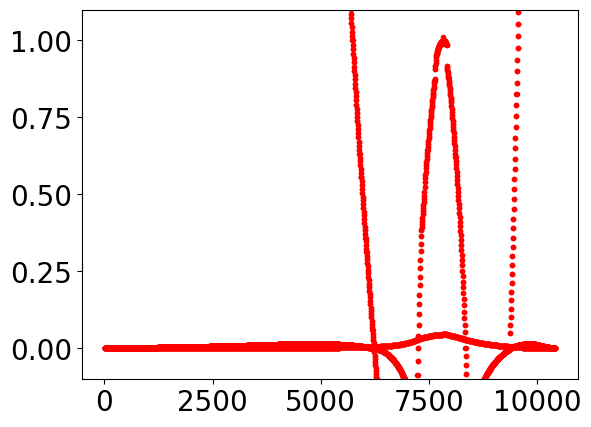

In [ ]:
for i in range(len(floke)-1):
  plt.plot(i, floke[i+1],  '.', color = 'r')
plt.ylim(-0.1, 1.1)

In [ ]:
stable = []
flag = 0
for i in range(len(dp_EM)):
    for j in range(6):
        if abs(dp_EM[i, j+6]+dp_EM[i, j+11]*1j) > 1.005:
            flag = 1
    if flag == 0:
        stable.append(i)
    flag = 0

In [ ]:
stable, len(dp_EM)

([], 1738)

Text(0, 0.5, 'z, km')

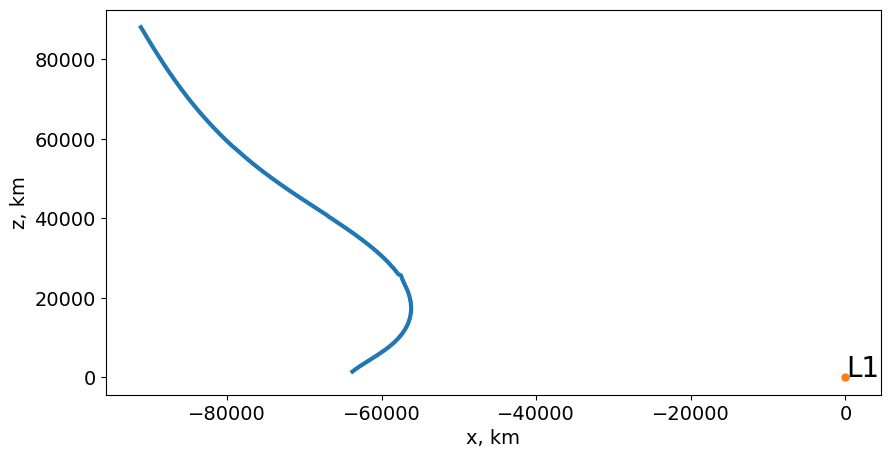

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot((dp_EM[: , 0] - model.L2) * model.R, dp_EM[: , 1] * model.R, lw=3)
ax.plot((dp_EM[stable, 0] - model.L2) * model.R, dp_EM[stable, 1] * model.R, '.r', ms=5)
ax.plot(0, 0,'.', markersize=10)
ax.text(150, 150, 'L1', size=20)
ax.set_xlabel('x, km')
ax.set_ylabel('z, km')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


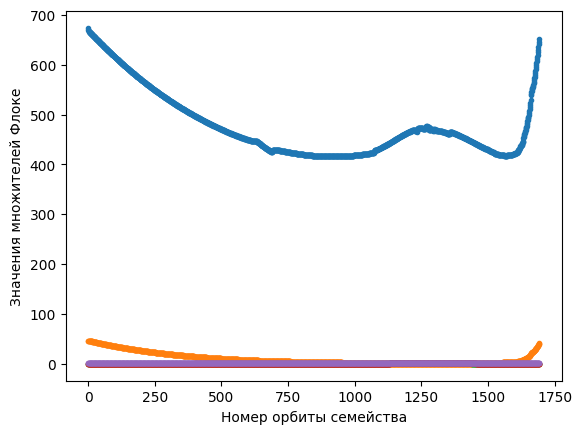

In [ ]:
dp_EM1 = np.loadtxt('dp_EM(1).txt')
rs =  np.arange(len(dp_EM1))
plt.plot(rs[:], dp_EM1[:, 6]+dp_EM1[:, 11]*1j, '.');
plt.plot(rs, dp_EM1[:, 7] + dp_EM1[:, 12] *1j, '.');
plt.plot(rs, dp_EM1[:, 8] + dp_EM1[:, 13] *1j, '.');
plt.plot(rs, dp_EM1[:, 9] + dp_EM1[:, 14] *1j, '.');
plt.plot(rs, dp_EM1[:, 10] + dp_EM1[:, 15] *1j, '.');
plt.xlabel("Номер орбиты семейства")
plt.ylabel("Значения множителей Флоке")
plt.savefig('floke.pdf')
#plt.ylim(0.98, 1.005)